8.10. convert relative columns to difference based features instead of running sums

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from math import radians, cos, sin, asin, sqrt

In [2]:
def build_sample_indices(data, col):
    """
    Builds sequence indices based on duration data
    Iterate over the rows in data and increment index whenever duration == 0
    
    Args:
        data (pd.DataFrame) : The dataframe whose indices are to be built.
        col (string) : The column of the dataframe with respect to the indexing
    Returns:
         data (pd.Series) : Data with an added column for the sequence indices
    """
    
    idx = 0
    seq_indices = []
    for _, row in data.iterrows():
        if row[col] == 0:
            #increment index and begin new sequence
            idx += 1
            seq_indices.append(idx)
        else:
            seq_indices.append(idx)
    
    data['sequence'] = seq_indices
    
    return data

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [4]:
def compute_distance_between_rows(row1, row2, gpslat_col, gpslong_col):
    """
    Compute the haversine distance given two rows sliced from a pd.DataFrame.
    Rows are expected to be identical in their columns
    
    Args:
        row1 (pd.Series of shape (1, n_features)) 
        row2 (pd.Series of shape (1, n_features))
        gpslat_col (string) : the identifier of the column of gps latitude in both rows
        gpslong_col (string) : the identifier of the column of gps longitude in both rows
    
    Returns:
        distance (float)
    """
    lon1 = row1[gpslong_col]
    lat1 = row1[gpslat_col]
    lon2 = row2[gpslong_col]
    lat2 = row2[gpslat_col]
        
    return haversine(lon1, lat1, lon2, lat2)


In [5]:
def convert_sequence_to_relative(seq):
    """
    Converts gpslat, gpslong and altitude to running difference metrics
    
    Args:
        seq (pd.DataFrame) : the sequence to be converted
    
    Returns:
        distance (pd.Series) : distance offset (meters) from the previous value in the series
        rel_altitude (pd.Series) : altitude offset (meters) from the previous value in the series
        rel_soc (pd.Series) : the additive inverse of SOC offset from beginning of the series
    """
    first_row = seq.iloc[0,:]
    args = (first_row, 'gpslat', 'gpslong')
    
    distance = seq.apply(compute_distance_between_rows, args=args, axis=1)
    distance = distance.diff()
    distance.iloc[0] = 0
    
    rel_altitude = seq.apply(lambda row : row['altitude'] - first_row['altitude'], axis=1)
    rel_altitude = rel_altitude.diff()
    rel_altitude.iloc[0] = 0
    
    rel_soc = seq.apply(lambda row : -1*(row['soc'] - first_row['soc']), axis=1)
    
    return distance, rel_altitude, rel_soc


In [6]:
def convert_dataset_to_relative(data):
    """
    Iterate over sequences in the whole dataset and make the necessary conversions
    """
    seq_ids = list(data['sequence'].unique())
    
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        distance, rel_altitude, rel_soc = convert_sequence_to_relative(seq)
        data.loc[seq.index, 'distance'] = distance
        data.loc[seq.index, 'rel_altitude'] = rel_altitude
        data.loc[seq.index, 'rel_soc'] = rel_soc
    
    data = data.drop(['gpslat', 'gpslong', 'altitude', 'soc'], axis=1)
    
    return data


In [7]:
def remove_outliers(data):
    
    # for each sequence in data, replace the temp with median
    # drop unusually high values in speed
    seq_ids = list(data['sequence'].unique())
    data = data.drop(index=data[data['speed'] > 100].index)
    
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        data.loc[seq.index, 'temp'] = np.median(seq['temp'])
                
    return data

In [8]:
def preprocess_dataset(data):
    
    #Apply transformations
    data = build_sample_indices(data, 'duration')
    data = remove_outliers(data)
    data_rel = convert_dataset_to_relative(data)
    
    return data_rel, data
    

-----------------

In [9]:
data = pd.read_csv('../data/trips_bulk.csv')

In [10]:
len(data)

3956979

In [11]:
data.head()

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration
0,2017-01-01 12:07:35,22.273872,60.510728,56.888984,25.570312,57.516667,-0.661392,0
1,2017-01-01 12:07:40,22.273635,60.510382,56.192922,27.574219,57.420000,-0.677215,5
2,2017-01-01 12:07:45,22.273475,60.509920,55.654167,30.535156,57.320000,-0.693038,10
3,2017-01-01 12:07:50,22.273783,60.509452,55.177280,31.160156,57.233333,-0.708861,15
4,2017-01-01 12:07:55,22.274570,60.509088,53.519203,34.199219,57.140000,-0.724684,20


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025CEF00A898>,
      dtype=object)

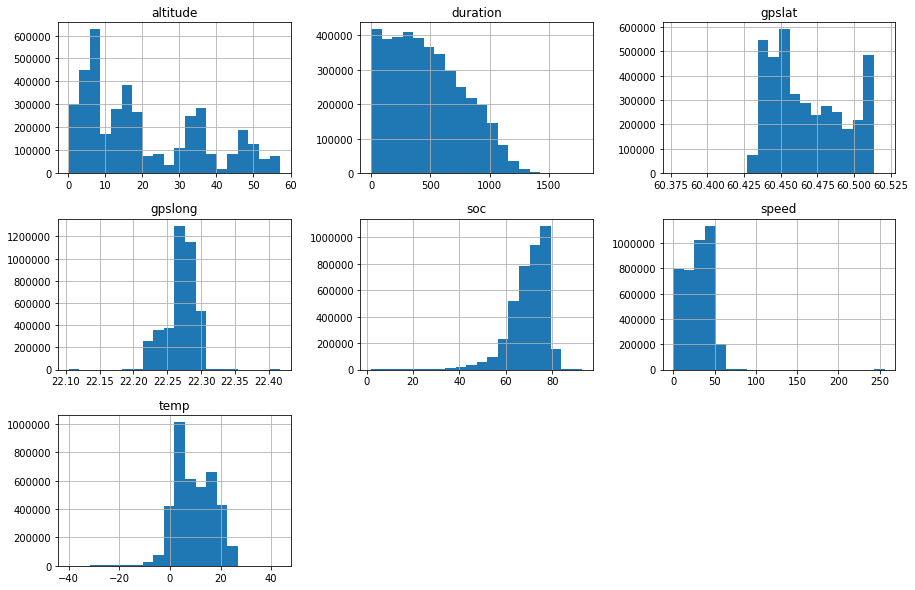

In [12]:
data.hist(bins=20, figsize=(15,10))

Outliers will be handled in remove_outliers

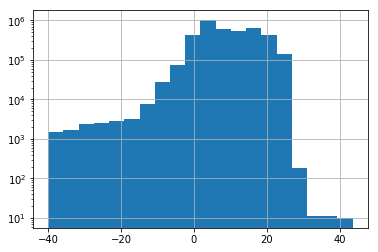

In [13]:
data['temp'].hist(bins=20)
plt.yscale('log', nonposy='clip')

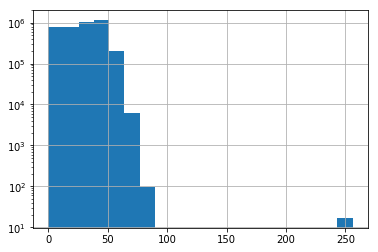

In [14]:
data['speed'].hist(bins=20)
plt.yscale('log', nonposy='clip')

### Test with a smaller subset

In [15]:
data_rel, data = preprocess_dataset(data[0:10000])

C:\Users\paho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
data.head()

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration,sequence,distance,rel_altitude,rel_soc
0,2017-01-01 12:07:35,22.273872,60.510728,56.888984,25.570312,57.516667,-0.428363,0,1,0.000000,0.000000,-0.000000
1,2017-01-01 12:07:40,22.273635,60.510382,56.192922,27.574219,57.420000,-0.428363,5,1,0.040666,-0.696062,0.096667
2,2017-01-01 12:07:45,22.273475,60.509920,55.654167,30.535156,57.320000,-0.428363,10,1,0.051802,-0.538756,0.196667
3,2017-01-01 12:07:50,22.273783,60.509452,55.177280,31.160156,57.233333,-0.428363,15,1,0.049573,-0.476887,0.283333
4,2017-01-01 12:07:55,22.274570,60.509088,53.519203,34.199219,57.140000,-0.428363,20,1,0.044282,-1.658076,0.376667


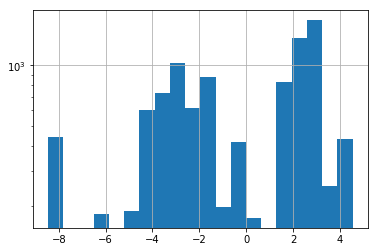

In [17]:
data['temp'].hist(bins=20)
plt.yscale('log', nonposy='clip')

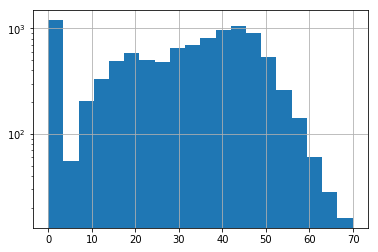

In [18]:
data['speed'].hist(bins=20)
plt.yscale('log', nonposy='clip')

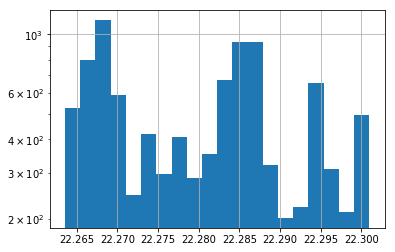

In [19]:
data['gpslong'].hist(bins=20)
plt.yscale('log', nonposy='clip')

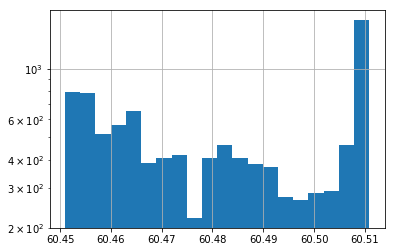

In [20]:
data['gpslat'].hist(bins=20)
plt.yscale('log', nonposy='clip')

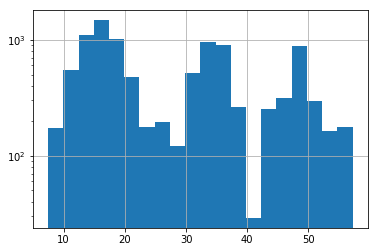

In [21]:
data['altitude'].hist(bins=20)
plt.yscale('log', nonposy='clip')

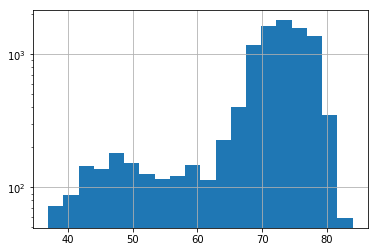

In [22]:
data['soc'].hist(bins=20)
plt.yscale('log', nonposy='clip')

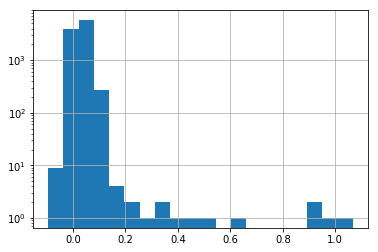

In [23]:
data['distance'].hist(bins=20)
plt.yscale('log', nonposy='clip')

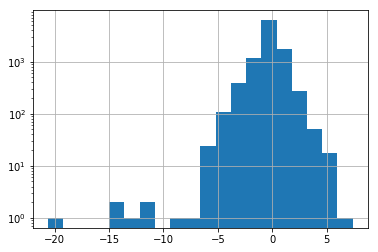

In [24]:
data['rel_altitude'].hist(bins=20)
plt.yscale('log', nonposy='clip')

M examples

In [25]:
len(data['sequence'].unique())

49

In [26]:
data_rel.isna().sum()

timestamp       0
speed           0
temp            0
duration        0
sequence        0
distance        0
rel_altitude    0
rel_soc         0
dtype: int64

In [27]:
data_rel.to_csv('../data/trips_diff_test.csv', index=False)

***